In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns

DATA_DIR = Path('.')
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import matplotlib as mpl
mpl.rcParams["axes.formatter.useoffset"] = False

## Read in data + clean up

In [4]:
with pd.ExcelFile(DATA_DIR / '2016 BEPS CbC Report V1.xlsx') as xls:
    t1 = pd.read_excel(xls, '2016 Table 1', header=0, index_col=0) 

In [5]:
# Clean up unwanted rows in Table 1
t1 = t1[pd.Series(t1.index).notnull().values]  # strip out rows where country name is blank
t1 = t1[~pd.Series(t1.index).isin(['Grand Total', 'Total per Hyperion Report', 'CHECK', 'Check TOTAL to 10-K']).values]  # we don't need these rows either

In [6]:
t1.index = [x.replace(' Total', '') for x in t1.index]

## Read in CT rates

In [60]:
# Read in CT rates data
with pd.ExcelFile(DATA_DIR / 'CT rates uptp2016.xlsx') as xls:
    ctrates = pd.read_excel(xls, 'Raw', header=0, index_col=0)

In [62]:
ctrates[2016]

Location
Afghanistan                          20.00
Albania                              15.00
Algeria                              26.00
Angola                               30.00
Argentina                            35.00
Armenia                              20.00
Aruba                                25.00
Australia                            30.00
Austria                              25.00
Bahamas                               0.00
Bahrain                               0.00
Bangladesh                           25.00
Barbados                             25.00
Belarus                              18.00
Belgium                              33.99
Bermuda                               0.00
Bolivia                              25.00
Bonaire, Saint Eustatius and Saba     0.00
Bosnia and Herzegovina               10.00
Botswana                             22.00
Brazil                               34.00
Bulgaria                             10.00
Cambodia                             20.00
Ca

In [8]:
# For countries missing 2016 CT rates, replace with their 2015 value (e.g. Switzerland)
ctrates.loc[ctrates[2016].isnull(), 2016] = ctrates.loc[ctrates[2016].isnull(), 2015]

In [9]:
# Which countries in t1 not in ctrates?
set(t1.index).difference(set(ctrates.index))

{'Korea', 'Puerto Rico', 'Slovak Republic'}

In [10]:
# Rename these
country_name_map = {
    'Hong Kong SAR': 'Hong Kong',
    'Korea, Republic of': 'Korea',
    'Slovakia': 'Slovak Republic'
} 
ctrates.index = pd.Series(ctrates.index).apply(lambda x: country_name_map[x] if x in country_name_map else x)

In [11]:
set(t1.index).difference(set(ctrates.index))

{'Puerto Rico'}

In [12]:
puerto_rico = pd.DataFrame({'Location': ['Puerto Rico'], 2016: [39]}).set_index('Location')

In [13]:
ctrates = ctrates.append(puerto_rico)

In [14]:
t1 = t1.reset_index()

In [15]:
t1.head()

,index,Unrelated Parties Revenue,Related Parties Revenue,Total Revenue,Profit (Loss) Before Tax,Income Tax Paid including WHT,Income Tax Accrued - CY,Stated Capital,Accumulated Earnings,Number of Employees,Tangible Assets
0,Argentina,1.000562e+07,-135313.07,9.870311e+06,2311313.62,3.686176e+05,832558.66,1131130.94,4.028037e+06,154.0,230456.70
1,Austria,1.985337e+07,-504707.23,1.934867e+07,4179738.08,1.396659e+06,1024016.52,538392.26,5.794124e+06,165.0,544871.36
2,Australia,4.255386e+08,-4866044.66,4.206726e+08,52202512.93,1.898934e+07,33535442.92,57720358.38,1.054250e+08,2336.4,13029016.72
3,Belgium,9.367550e+07,-2609321.17,9.106618e+07,7506384.33,4.067275e+06,3689565.33,11271803.91,4.802068e+06,625.5,1921804.05
4,Brazil,2.923914e+08,-809820.45,2.915816e+08,33910483.05,1.752195e+07,32575451.86,46396578.59,5.561510e+07,2629.0,11984801.79


In [16]:
# Get rid of indexes
t1.columns = ['Country'] + list(t1.columns.values)[1:]

In [17]:
ctrates = ctrates.reset_index()

In [18]:
ctrates = ctrates[['Location', 2016]]

In [19]:
ctrates.columns = ['Country', 'CTRate']

In [20]:
# Merge ctrates in
t1 = pd.merge(left=t1, right=ctrates, on='Country')

# Ratios

In [21]:
t1.columns

Index(['Country', 'Unrelated Parties Revenue', 'Related Parties Revenue',
       'Total Revenue', 'Profit (Loss) Before Tax',
       'Income Tax Paid including WHT', 'Income Tax Accrued - CY',
       'Stated Capital', 'Accumulated Earnings', 'Number of Employees',
       'Tangible Assets', 'CTRate'],
      dtype='object')

In [22]:
# CTRate is current percentage out of 100
t1['CTRate'] = t1.CTRate.apply(lambda x: x / 100)

In [23]:
# Effective Tax Rate
t1['ETR'] = t1['Income Tax Paid including WHT'] / t1['Profit (Loss) Before Tax']

In [24]:
# Tax Elasticity
t1['TaxElasticity'] = t1['ETR'] / t1['CTRate']

In [25]:
# Operating Margin
t1['OM'] = t1['Profit (Loss) Before Tax'] / t1['Total Revenue']

In [26]:
# Related Party Revenue Intensity
t1['RPInt'] = t1['Related Parties Revenue'] / t1['Total Revenue']

In [27]:
# Employee Intensity
t1['AssetPerEE'] = t1['Tangible Assets'] / t1['Number of Employees']
t1['PBTPerEE'] = t1['Profit (Loss) Before Tax'] / t1['Number of Employees']

In [28]:
# Return On Capital
t1['ROC'] = t1['Accumulated Earnings'] / t1['Stated Capital']

# Graphs

In [29]:
t1 = t1.set_index('Country')

#### Effective Tax Rate
- Median = 22.9%
- Mean = 22.4%

In [30]:
t1.ETR.describe()

count    61.000000
mean      0.224307
std       0.162968
min      -0.007199
25%       0.085140
50%       0.229055
75%       0.349322
max       0.604616
Name: ETR, dtype: float64

In [31]:
t1.CTRate.describe()

count    62.000000
mean      0.242419
std       0.076937
min       0.100000
25%       0.192500
50%       0.232500
75%       0.295400
max       0.550000
Name: CTRate, dtype: float64

In [32]:
t1.TaxElasticity.describe()

count    61.000000
mean      0.930594
std       0.621248
min      -0.039997
25%       0.455669
50%       1.045776
75%       1.336600
max       2.336884
Name: TaxElasticity, dtype: float64

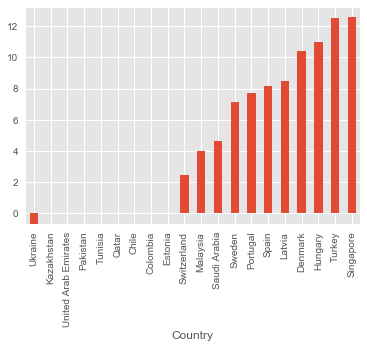

In [33]:
col = 'ETR'
t1.sort_values(by=col, ascending=True).head(20)[col].apply(lambda x: 100*x).plot(kind='bar')

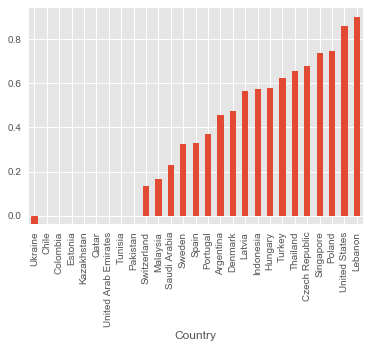

In [34]:
t1[t1.TaxElasticity < 0.9].sort_values(by='TaxElasticity', ascending=True).TaxElasticity.plot(kind='bar')

In [35]:
t1.OM.describe()

count    61.000000
mean          -inf
std            NaN
min           -inf
25%       0.124093
50%       0.161494
75%       0.215000
max       0.301441
Name: OM, dtype: float64

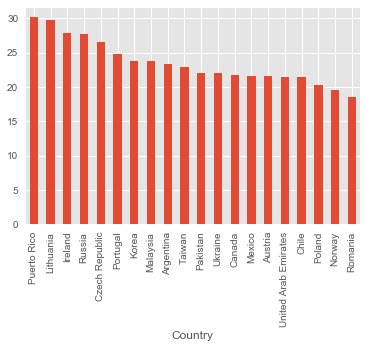

In [36]:
col = 'OM'
t1.sort_values(by=col, ascending=False).head(20)[col].apply(lambda x: 100*x).plot(kind='bar')

In [37]:
t1.RPInt.describe()

count    60.000000
mean     -0.014435
std       0.036986
min      -0.051609
25%      -0.033651
50%      -0.020947
75%      -0.009795
max       0.203346
Name: RPInt, dtype: float64

C:\Users\Shan.sun\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


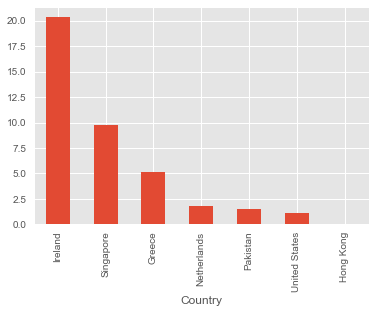

In [38]:
col = 'RPInt'
t1.sort_values(by=col, ascending=False)[t1.RPInt>0][col].apply(lambda x: 100*x).plot(kind='bar')

C:\Users\Shan.sun\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


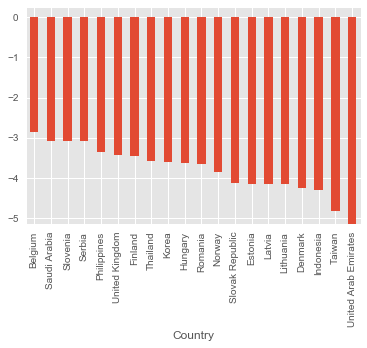

In [39]:
t1.sort_values(by=col, ascending=False)[t1.RPInt<0].tail(20)[col].apply(lambda x: 100*x).plot(kind='bar')

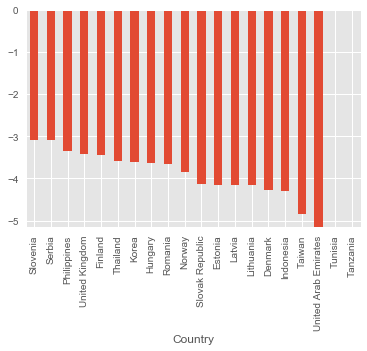

In [40]:
t1.sort_values(by=col, ascending=False).tail(20)[col].apply(lambda x: 100*x).plot(kind='bar')

In [41]:
t1.AssetPerEE.describe()

count       60.000000
mean      4351.651987
std       8965.483863
min        262.471923
25%       1358.894780
50%       2256.846204
75%       3458.650445
max      65811.840236
Name: AssetPerEE, dtype: float64

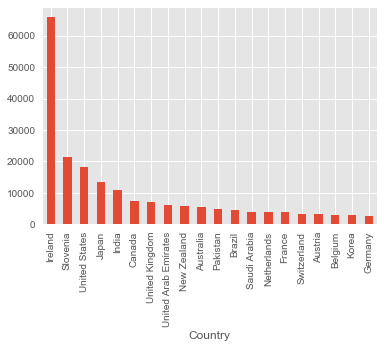

In [42]:
col = 'AssetPerEE'
t1.sort_values(by=col, ascending=False).head(20)[col].plot(kind='bar')

In [43]:
t1.PBTPerEE.describe()

count    6.100000e+01
mean             -inf
std               NaN
min              -inf
25%      9.318525e+03
50%      1.372362e+04
75%      2.316966e+04
max      1.762681e+05
Name: PBTPerEE, dtype: float64

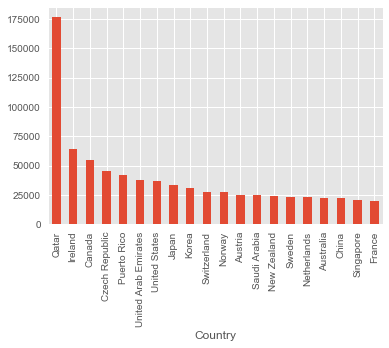

In [44]:
col = 'PBTPerEE'
t1.sort_values(by=col, ascending=False)[0:20][col].plot(kind='bar')

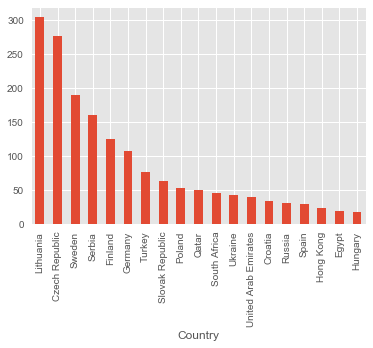

In [45]:
t1.sort_values(by='ROC', ascending=False)[1:20].ROC.plot(kind='bar')

In [46]:
t1.columns

Index(['Unrelated Parties Revenue', 'Related Parties Revenue', 'Total Revenue',
       'Profit (Loss) Before Tax', 'Income Tax Paid including WHT',
       'Income Tax Accrued - CY', 'Stated Capital', 'Accumulated Earnings',
       'Number of Employees', 'Tangible Assets', 'CTRate', 'ETR',
       'TaxElasticity', 'OM', 'RPInt', 'AssetPerEE', 'PBTPerEE', 'ROC'],
      dtype='object')

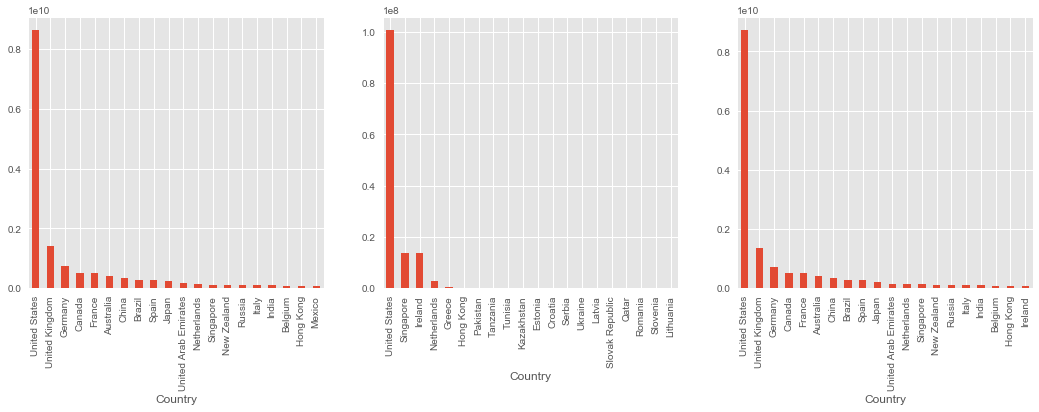

In [47]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=False, figsize=(18, 5))
for i, col in enumerate(['Unrelated Parties Revenue', 'Related Parties Revenue', 'Total Revenue']):
    t1.sort_values(by=col, ascending=False)[0:20][col].plot(kind='bar', ax=axes[i])

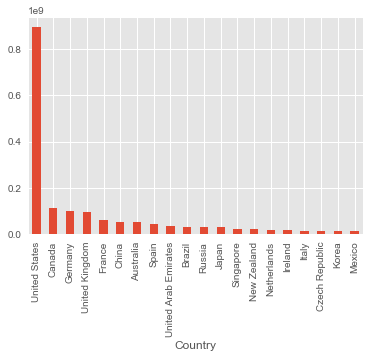

In [48]:
col = 'Profit (Loss) Before Tax'
t1.sort_values(by=col, ascending=False)[0:20][col].plot(kind='bar')

In [49]:
t1.columns

Index(['Unrelated Parties Revenue', 'Related Parties Revenue', 'Total Revenue',
       'Profit (Loss) Before Tax', 'Income Tax Paid including WHT',
       'Income Tax Accrued - CY', 'Stated Capital', 'Accumulated Earnings',
       'Number of Employees', 'Tangible Assets', 'CTRate', 'ETR',
       'TaxElasticity', 'OM', 'RPInt', 'AssetPerEE', 'PBTPerEE', 'ROC'],
      dtype='object')

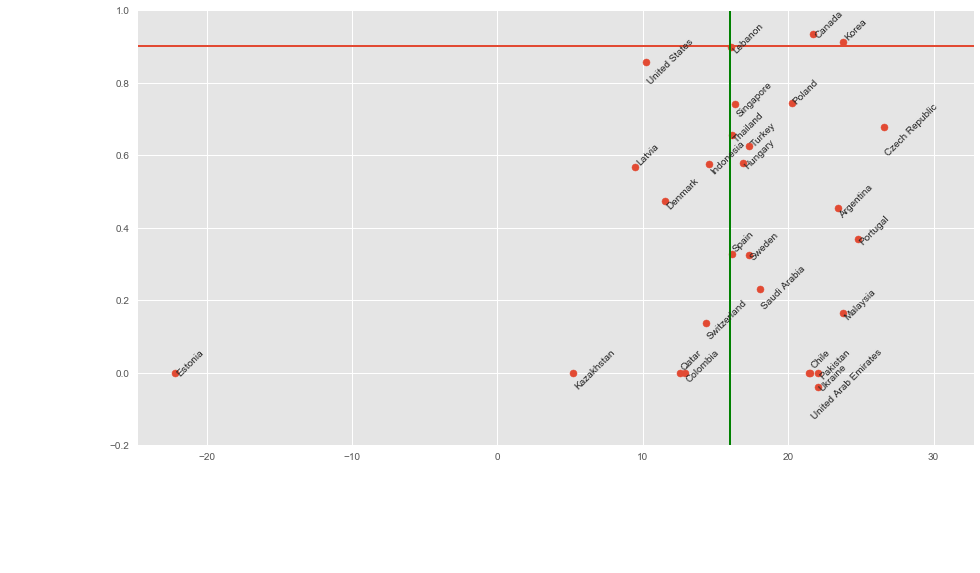

In [50]:
# Tax elasticity vs OM
fig = plt.figure(figsize=(15,8))

t1_not_inf = t1.copy()
t1_not_inf['OM'] = t1_not_inf.OM.replace([np.inf, -np.inf], np.nan)
t1_not_inf = t1_not_inf.dropna(subset=["OM"])

x = t1_not_inf.OM * 100
y = t1_not_inf.TaxElasticity
plt.scatter(x, y)

for i, txt in enumerate(t1_not_inf.index):
    plt.annotate(txt, (x.iloc[i], y.iloc[i]+.05), rotation=45)

    plt.axhline(0.9, linewidth=2)
#    plt.axhline(-0.5, linewidth=2)
    plt.axvline(16, linewidth=2, color='g')
    plt.ylim(-0.2,1)
plt.show()

### Correlation heatmap

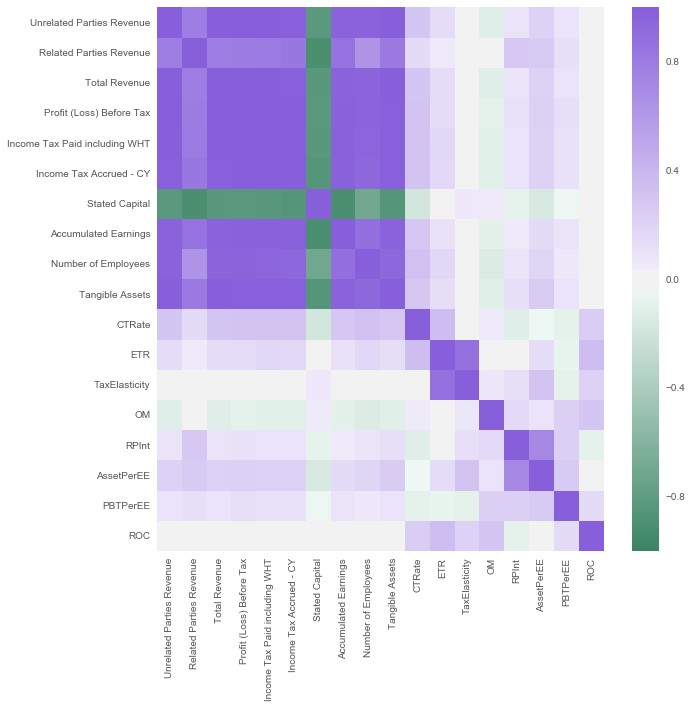

In [51]:
fig, ax = plt.subplots(figsize=(10,10))
colour_map = sns.diverging_palette(150, 275, as_cmap=True)
sns.heatmap(t1.corr(), cmap=colour_map, ax=ax)

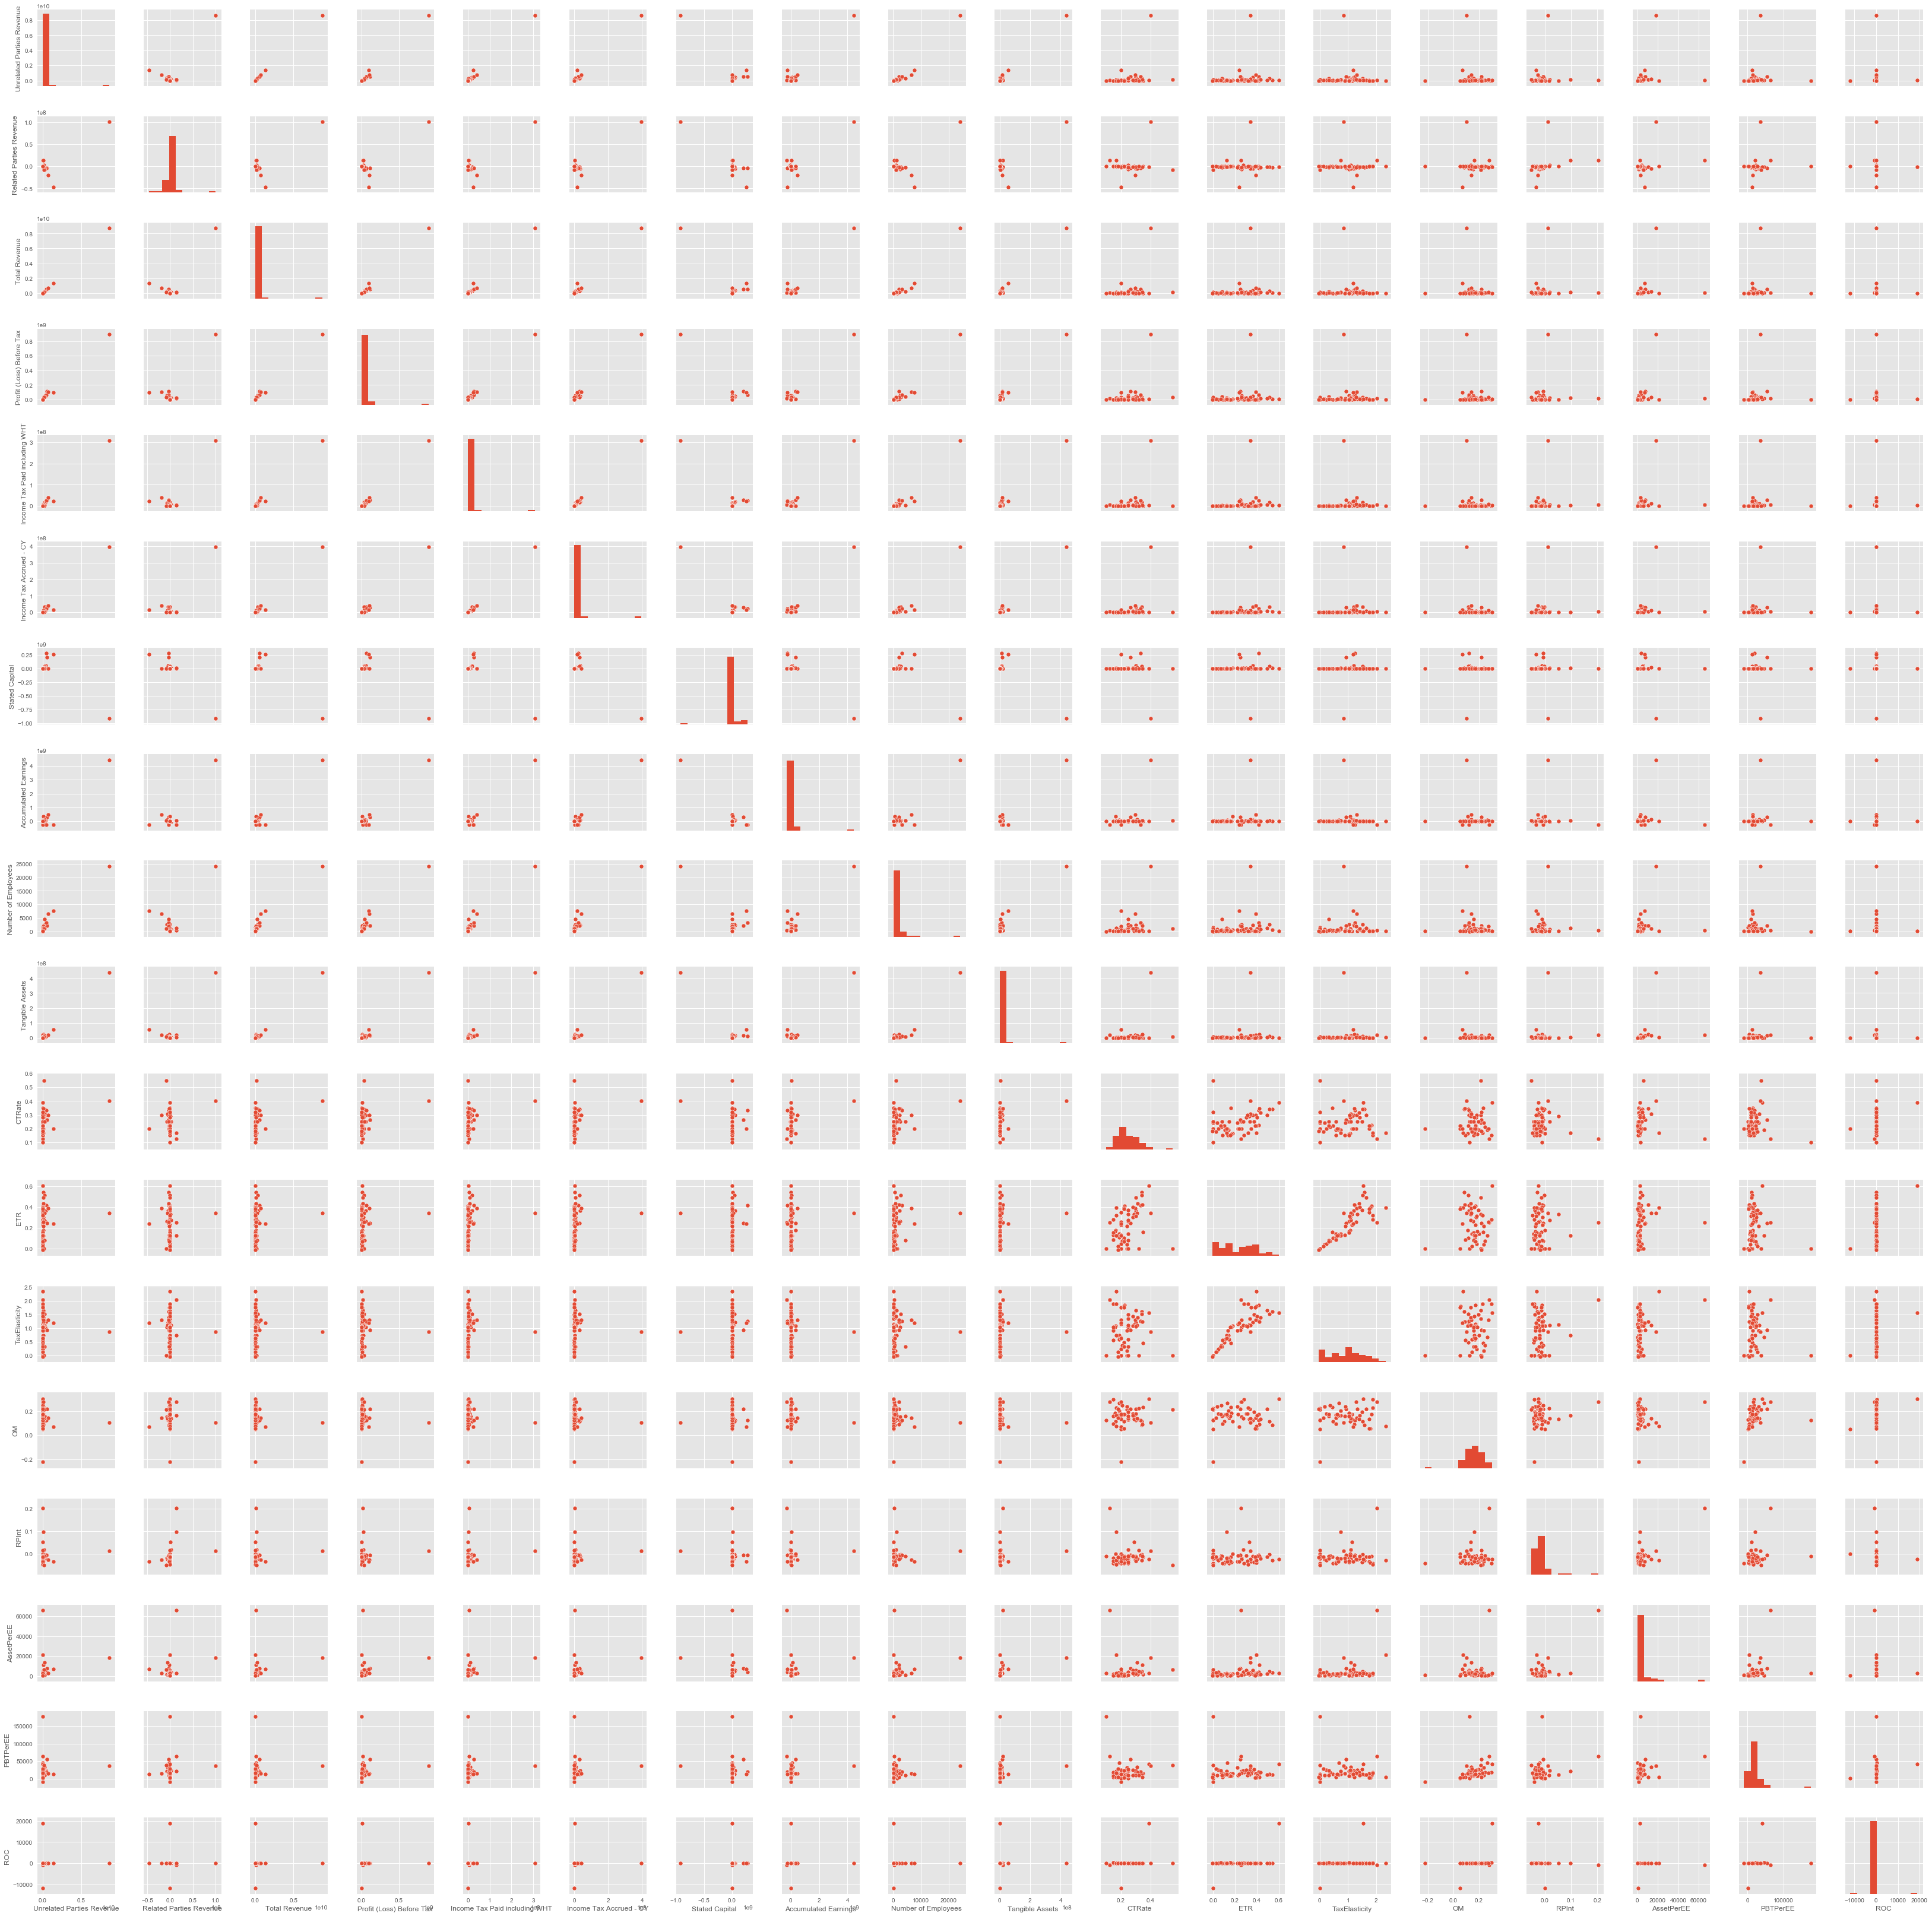

In [52]:
sns.pairplot(t1.dropna())

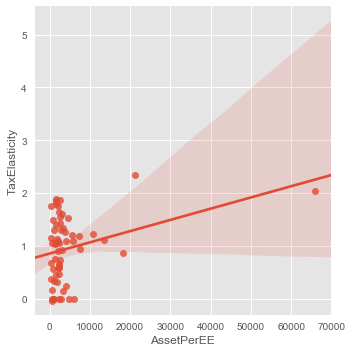

In [53]:
# TaxElasticity has strongest correlation with AssetPerEE
sns.lmplot(y='TaxElasticity', x='AssetPerEE', data=t1)

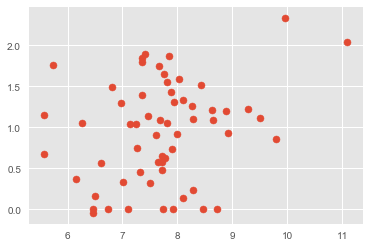

In [54]:
# Does log x scale make more sense? Or are these outliers?
x = np.log(t1.AssetPerEE)
y = t1.TaxElasticity
plt.scatter(x, y)

### Add country names to TaxElasticity vs PBTPerEE

In [55]:
t1.PBTPerEE.describe()

count    6.100000e+01
mean             -inf
std               NaN
min              -inf
25%      9.318525e+03
50%      1.372362e+04
75%      2.316966e+04
max      1.762681e+05
Name: PBTPerEE, dtype: float64

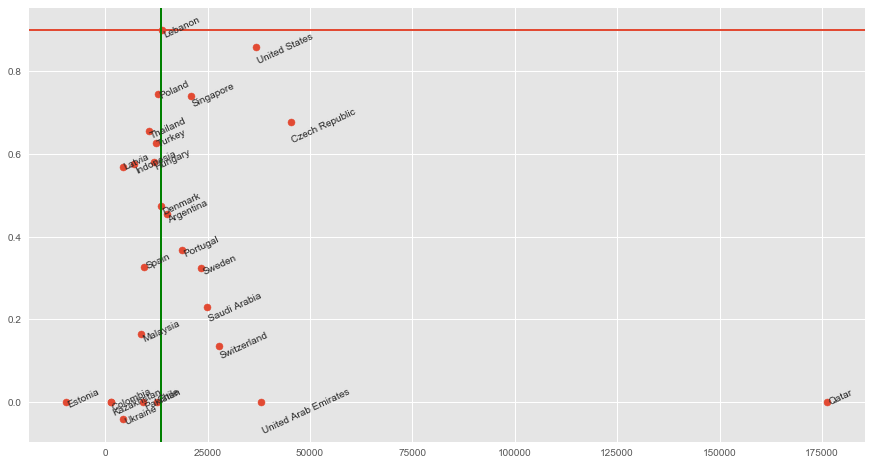

In [56]:
# Tax elasticity vs PBTPerEE
fig = plt.figure(figsize=(15,8))

col = 'PBTPerEE'
t1_not_inf = t1.copy()
t1_not_inf[col] = t1_not_inf[col].replace([np.inf, -np.inf], np.nan)
t1_not_inf = t1_not_inf.dropna(subset=[col])
t1_not_inf = t1_not_inf[t1_not_inf.TaxElasticity < 0.9]

x = t1_not_inf[col]
y = t1_not_inf.TaxElasticity
plt.scatter(x, y)

for i, txt in enumerate(t1_not_inf.index):
    plt.annotate(txt, (x.iloc[i], y.iloc[i]+.02), rotation=25)

    plt.axhline(0.9, linewidth=2)
    plt.axvline(t1[col].median(), linewidth=2, color='g')
#    plt.ylim(-0.2,1)
plt.show()

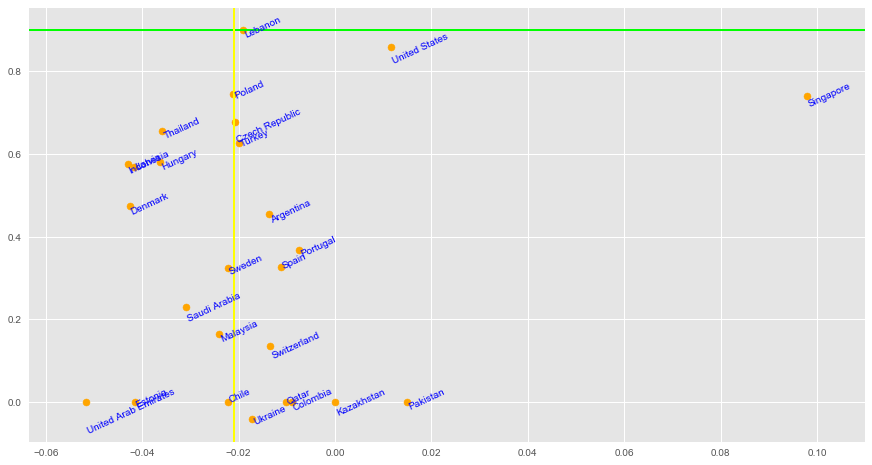

In [57]:
# Tax elasticity vs RPInt
fig = plt.figure(figsize=(15,8))

col = 'RPInt'
t1_not_inf = t1.copy()
t1_not_inf[col] = t1_not_inf[col].replace([np.inf, -np.inf], np.nan)
t1_not_inf = t1_not_inf.dropna(subset=[col])
t1_not_inf = t1_not_inf[t1_not_inf.TaxElasticity < 0.9]

x = t1_not_inf[col]
y = t1_not_inf.TaxElasticity
plt.scatter(x, y, color='orange')

for i, txt in enumerate(t1_not_inf.index):
    plt.annotate(txt, (x.iloc[i], y.iloc[i]+.02), rotation=25, color='blue')

    plt.axhline(0.9, linewidth=2, color='lime')
    plt.axvline(t1[col].median(), linewidth=2, color='yellow')
#    plt.ylim(-0.2,1)
plt.show()

In [58]:
len(t1[t1.TaxElasticity < 0.9])

27

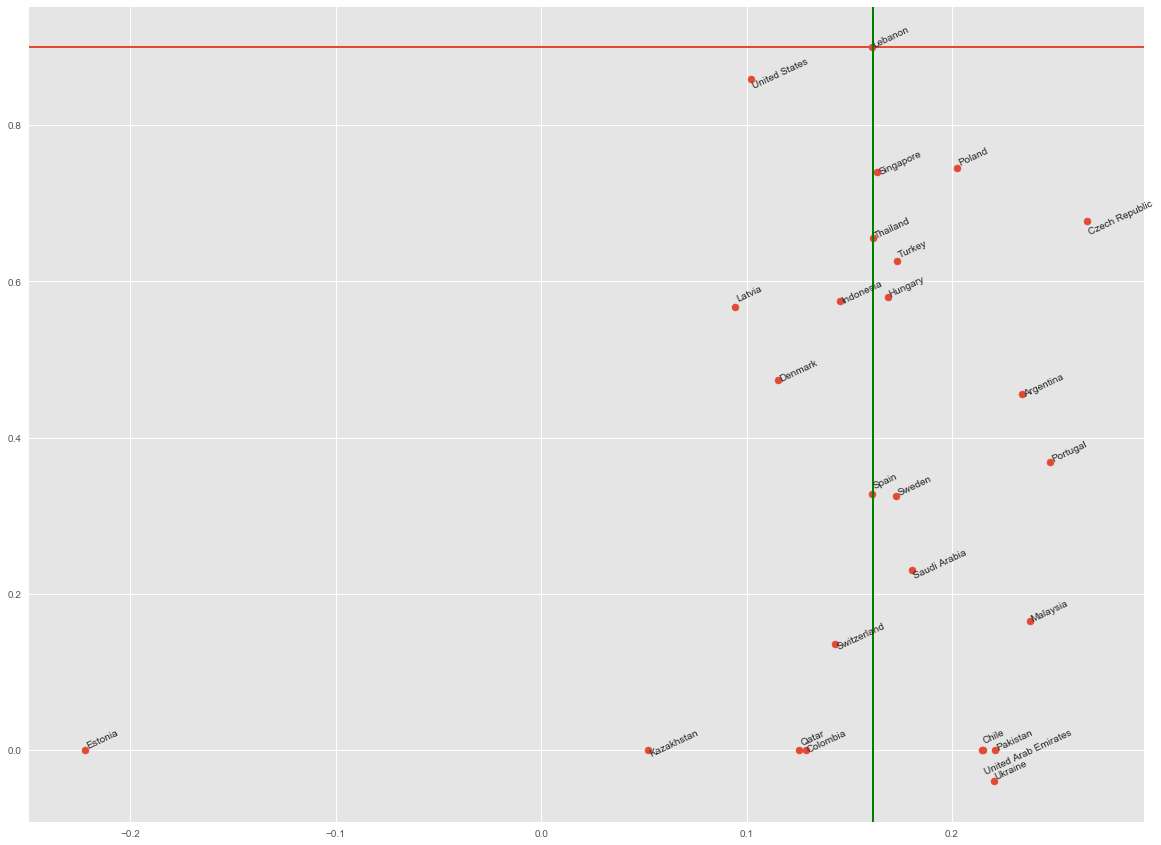

In [59]:
# Cash Tax ETR vs OM

fig = plt.figure(figsize=(20,15))

col = 'OM'
t1_not_inf = t1.copy()
t1_not_inf[col] = t1_not_inf[col].replace([np.inf, -np.inf], np.nan)
t1_not_inf = t1_not_inf.dropna(subset=[col])
t1_not_inf = t1_not_inf[t1_not_inf.TaxElasticity < 0.9]

x = t1_not_inf[col]
y = t1_not_inf.TaxElasticity
plt.scatter(x, y)

for i, txt in enumerate(t1_not_inf.index):
    plt.annotate(txt, (x.iloc[i], y.iloc[i]+.02), rotation=25)

    plt.axhline(0.9, linewidth=2)
    plt.axvline(t1[col].median(), linewidth=2, color='g')
#    plt.ylim(-0.2,1)
plt.show()